In [ ]:
# A5
# I built three models, the differnces only come from X (features).
# The first model uses 5 features mentioned in A7's paper;
# The second model drops 2 more features based on A7's result;
# The third model chooses features based on correlation.
# Each model is compared to the logistic regression model.
# Due to randomness, we might need to reset the value of eta based on the three graphs of accuracy, calibration, and parity.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import random
random.seed(10)

In [ ]:
# model I
# We only focused on age_cat, priors_count, gender_cat, charge_cat, length_stay, and sensitive feature.

In [ ]:
df = pd.read_csv("cleaned_compas.csv")
df = df.drop(columns=["Unnamed: 0"])

In [ ]:
df

,age_cat,priors_count,two_year_recid,race_cat,gender_cat,charge_cat,length_stay
0,0.5,0.0,1,0,0,1,0.5
1,0.0,1.0,1,0,0,1,0.0
2,0.5,1.0,1,1,0,1,0.0
3,0.5,0.0,0,1,1,0,0.0
4,0.0,0.5,1,1,0,1,0.0
...,...,...,...,...,...,...,...
5910,0.5,0.0,1,0,0,0,0.0
5911,0.0,0.0,0,0,0,1,0.0
5912,0.0,0.0,0,0,0,1,0.0
5913,0.0,0.0,0,0,0,1,0.0


In [ ]:
# Data splitting: Training:Testing:Validation=5:1:1
df_a = df[(df['race_cat'] == 0)]
df_c = df[(df['race_cat'] == 1)]
df_a = df_a.drop(columns=["race_cat"])
df_c = df_c.drop(columns=["race_cat"])

X_a = df_a.drop(columns = ['two_year_recid']).copy()
X_c = df_c.drop(columns = ['two_year_recid']).copy()
y_a = df_a['two_year_recid']
y_c = df_c['two_year_recid']

X_a_train, X_a_tv, y_a_train, y_a_tv = train_test_split(X_a, y_a, train_size=5/7)
X_a_test, X_a_valid, y_a_test, y_a_valid = train_test_split(X_a_tv, y_a_tv, test_size=1/2)
X_c_train, X_c_tv, y_c_train, y_c_tv = train_test_split(X_c, y_c, train_size=5/7)
X_c_test, X_c_valid, y_c_test, y_c_valid = train_test_split(X_c_tv, y_c_tv, test_size=1/2)

X_train = pd.concat([X_a_train, X_c_train])
y_train = pd.concat([y_a_train, y_c_train])
X_test = pd.concat([X_a_test, X_c_test])
y_test = pd.concat([y_a_test, y_c_test])
X_valid = pd.concat([X_a_valid, X_c_valid])
y_valid = pd.concat([y_a_valid, y_c_valid])

In [ ]:
X_a_train = t.tensor(np.array(X_a_train)).to(t.float32)
y_a_train = t.from_numpy(np.array(y_a_train).astype('float32')).reshape(X_a_train.shape[0], 1)
X_c_train = t.tensor(np.array(X_c_train)).to(t.float32)
y_c_train = t.from_numpy(np.array(y_c_train).astype('float32')).reshape(X_c_train.shape[0], 1)

X_a_test = t.tensor(np.array(X_a_test)).to(t.float32)
y_a_test = t.from_numpy(np.array(y_a_test).astype('float32')).reshape(X_a_test.shape[0], 1)
X_c_test = t.tensor(np.array(X_c_test)).to(t.float32)
y_c_test = t.from_numpy(np.array(y_c_test).astype('float32')).reshape(X_c_test.shape[0], 1)

X_a_valid = t.tensor(np.array(X_a_valid)).to(t.float32)
y_a_valid = t.from_numpy(np.array(y_a_valid).astype('float32')).reshape(X_a_valid.shape[0], 1)
X_c_valid = t.tensor(np.array(X_c_valid)).to(t.float32)
y_c_valid = t.from_numpy(np.array(y_c_valid).astype('float32')).reshape(X_c_valid.shape[0], 1)

In [ ]:
# We used 0.5 as threshold, and used Accuracy, Calibration, and Parity as evaluation metrics.

def Evaluation(Model_a, Model_c, X_a, y_a, X_c, y_c):
    y_a_pred = (Model_a(X_a) >= 0.5)
    y_c_pred = (Model_c(X_c) >= 0.5)
    acc_a  = t.sum(y_a_pred.flatten() == y_a.flatten()) / X_a.shape[0]
    acc_c  = t.sum(y_c_pred.flatten() == y_c.flatten()) / X_c.shape[0]
    resid_a = t.sum(y_a_pred == True) / X_a.shape[0]
    resid_c = t.sum(y_c_pred == True) / X_c.shape[0]
    accuracy = (acc_c + acc_a) / 2
    calibration = t.abs(acc_a - acc_c)
    parity = t.abs(resid_a - resid_c)
    return round(accuracy.item(), 4), round(calibration.item(), 4), round(parity.item(), 4)

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self,df):
        super(LogisticRegression, self).__init__()
        self.w = nn.Linear(df.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
    def forward(self, x):
        w = self.w(x)
        output = self.sigmod(w)
        return output

In [ ]:
class PRLoss():
    def __init__(self, eta=1.0):
        super(PRLoss, self).__init__()
        self.eta = eta
    def forward(self, output_a, output_c):
        # Approximating the true distribution of data by the sample distribution
        # eqn(9) in paper: hat{Pr}[y|s] = sum{(xi,si), s.t. si=s} Model(y|xi,s;theta) / |D[xs]|
        #D[xs]
        N_a = t.tensor(output_a.shape[0])
        N_c = t.tensor(output_c.shape[0])
        D_xs = t.stack((N_a, N_c), axis=0)
        # Pr[y|s]
        y_pred_a = t.sum(output_a)
        y_pred_c = t.sum(output_c)
        P_y_s = t.stack((y_pred_a, y_pred_c), axis=0) / D_xs
        # eqn(10) in paper: hat{Pr}[y] = sum{(xi,si)} Model(y|xi,si;theta) / |D[xs]|
        P = t.cat((output_a, output_c), 0)
        P_y = t.sum(P) / (X_a_train.shape[0]+X_c_train.shape[0])
        # P(yi|si)
        P_1_1 = t.log(P_y_s[1]) - t.log(P_y)
        P_0_1 = t.log(1-P_y_s[1]) - t.log(1-P_y)
        P_1_0 = t.log(P_y_s[0]) - t.log(P_y)
        P_0_0 = t.log(1-P_y_s[0]) - t.log(1-P_y)
        # eqn(11) in paper: prejudice remover regularizer R_PR(D, theta)
        # R_PR = sum{xi,si}sum{y} Model(y|xi,s;theta) * ln(hat{Pr}[y|si]/hat{Pr}[y])
        R_PR_1_1 = output_c * P_1_1
        R_PR_0_1 =(1- output_c) * P_0_1
        R_PR_1_0 = output_a * P_1_0
        R_PR_0_0 = (1- output_a) * P_0_0
        R_PR = t.sum(R_PR_1_1) + t.sum(R_PR_0_1) + t.sum(R_PR_1_0) + t.sum(R_PR_0_0)
        R_PR = self.eta * R_PR
        return R_PR

In [ ]:
class PRLR():
    def __init__(self, eta = 0.0, epochs = 300, lr = 0.01):
        super(PRLR, self).__init__()
        self.eta = eta
        self.epochs = epochs
        self.lr = lr
    def fit(self, X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
            X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test):
        model_a = LogisticRegression(X_a_train)
        model_c = LogisticRegression(X_c_train)
        criterion = nn.BCELoss(reduction='sum')
        PI = PRLoss(eta=self.eta) # Prejudice index
        epochs = self.epochs
        optimizer = t.optim.Adam(list(model_c.parameters())+list(model_a.parameters()), self.lr, weight_decay=1e-5)
        train_losses = []
        valid_losses = []
        for epoch in range(epochs):
            model_c.train()
            model_a.train()
            optimizer.zero_grad()
            output_a = model_a(X_a_train)
            output_c = model_c(X_c_train)
            logloss = criterion(output_a, y_a_train) + criterion(output_c, y_c_train)
            PRloss = PI.forward(output_a, output_c)
            loss = (PRloss + logloss)/5
            loss.backward()
            optimizer.step()
            train_losses.append(loss.detach().numpy())
            output_a = model_a(X_a_valid)
            output_c = model_c(X_c_valid)
            logloss = criterion(output_a, y_a_valid) + criterion(output_c, y_c_valid)
            PRloss = PI.forward(output_a, output_c)
            loss = PRloss + logloss
            valid_losses.append(loss.detach().numpy())
        model_a.eval()
        model_c.eval()
        eva = Evaluation(model_a, model_c, X_a_train, y_a_train, X_c_train, y_c_train)
        eva_valid = Evaluation(model_a, model_c, X_a_valid, y_a_valid, X_c_valid, y_c_valid)
        eva_test = Evaluation(model_c, model_a, X_a_test, y_a_test, X_c_test, y_c_test)
        plt.plot(list(range(epochs)), train_losses, label="train loss")
        plt.plot(list(range(epochs)), valid_losses, label="validation loss")
        plt.legend(loc="upper left")
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.show()
        return eva, eva_valid, eva_test

eta Value: 0


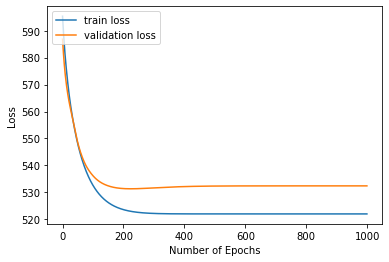

eta Value: 1


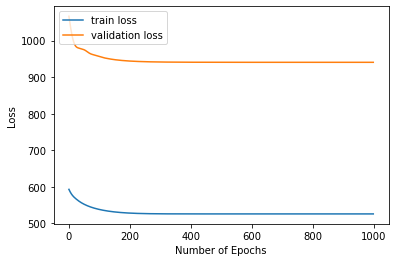

eta Value: 2


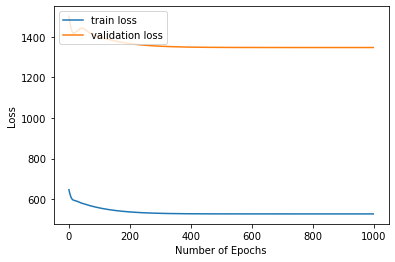

eta Value: 3


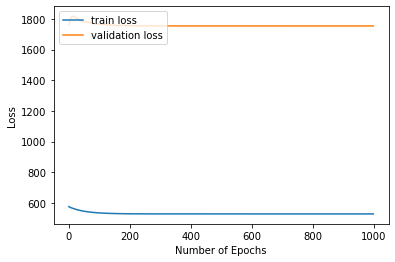

eta Value: 4


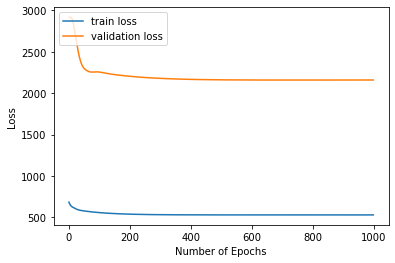

eta Value: 5


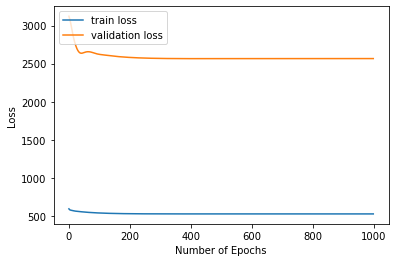

eta Value: 6


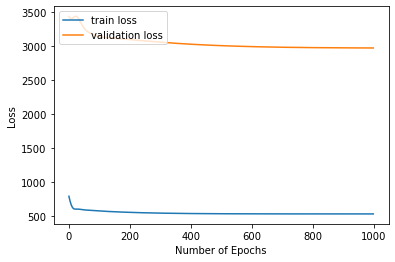

eta Value: 8


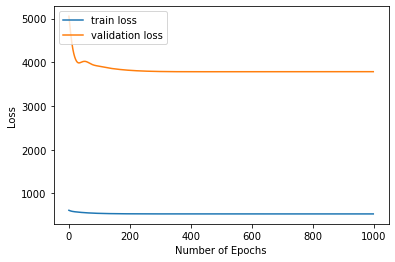

eta Value: 10


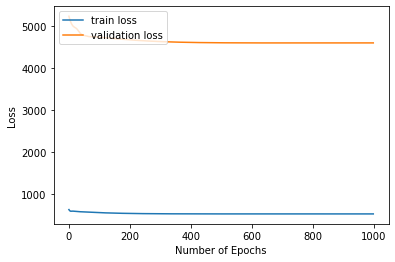

eta Value: 15


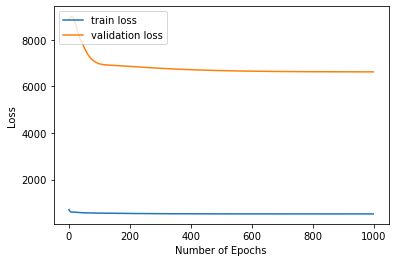

In [ ]:
eta_value_I = [0, 1, 2, 3, 4, 5, 6, 8, 10, 15]
evalu_I = list()
evalu_valid_I = list()
evalu_test_I = list()
for i in range(0, len(eta_value_I)):
    print("eta Value: %d" % eta_value_I[i])
    PR_I = PRLR(eta = eta_value_I[i], epochs = 1000, lr = 0.01)
    eva_I, eva_valid_I, eva_test_I = PR_I.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
                                              X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)
    evalu_I.append(eva_I)
    evalu_valid_I.append(eva_valid_I)
    evalu_test_I.append(eva_test_I)

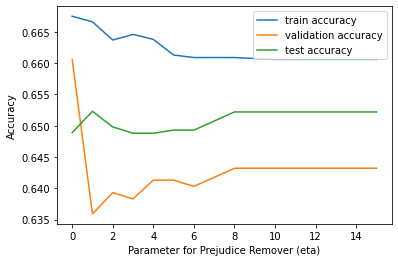

In [ ]:
eta_acc_train_I = [x[0] for x in evalu_I]
eta_acc_valid_I = [x[0] for x in evalu_valid_I]
eta_acc_test_I = [x[0] for x in evalu_test_I]
plt.plot(eta_value_I, eta_acc_train_I, label="train accuracy")
plt.plot(eta_value_I, eta_acc_valid_I, label="validation accuracy")
plt.plot(eta_value_I, eta_acc_test_I, label="test accuracy")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

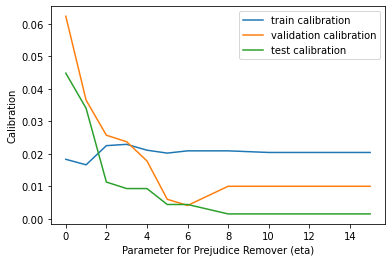

In [ ]:
eta_cal_train_I = [x[1] for x in evalu_I]
eta_cal_valid_I = [x[1] for x in evalu_valid_I]
eta_cal_test_I = [x[1] for x in evalu_test_I]
plt.plot(eta_value_I, eta_cal_train_I, label="train calibration")
plt.plot(eta_value_I, eta_cal_valid_I, label="validation calibration")
plt.plot(eta_value_I, eta_cal_test_I, label="test calibration")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Calibration')
plt.legend(loc="upper right")
plt.show()

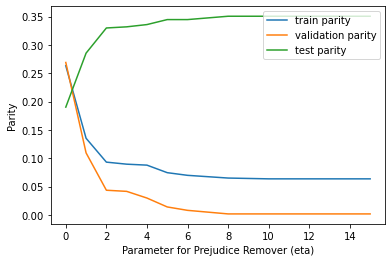

In [ ]:
eta_par_train_I = [x[2] for x in evalu_I]
eta_par_valid_I = [x[2] for x in evalu_valid_I]
eta_par_test_I = [x[2] for x in evalu_test_I]
plt.plot(eta_value_I, eta_par_train_I, label="train parity")
plt.plot(eta_value_I, eta_par_valid_I, label="validation parity")
plt.plot(eta_value_I, eta_par_test_I, label="test parity")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Parity')
plt.legend(loc="upper right")
plt.show()

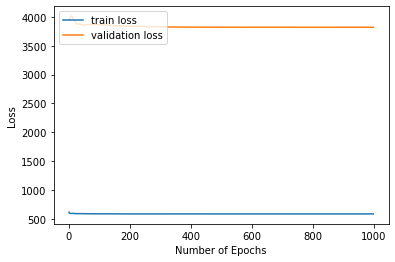

((0.5311, 0.0932, 0.187), (0.527, 0.0224, 0.1445), (0.5439, 0.1651, 0.0706))

In [ ]:
# Final model I
# To achieve high accuracy, low calibration and low parity, we decided to choose eta = 8.
# The outputs are (accuracy, calibration, parity) of training , validation, and testing sets.
PR_final_I = PRLR(eta = 8, epochs = 1000, lr = 0.01)
PR_final_I.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
               X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)

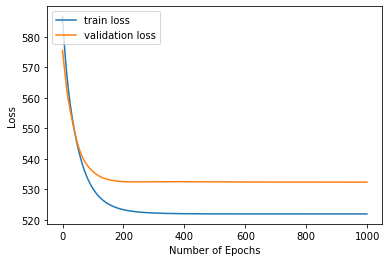

((0.6675, 0.0183, 0.2633), (0.6606, 0.0623, 0.2691), (0.6489, 0.0448, 0.1903))

In [ ]:
# Compared to logistic regression without prejudice remover regularizer
PR_0 = PRLR(eta = 0, epochs = 1000, lr = 0.01)
PR_0.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
         X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)

In [ ]:
# model II
# Based on A7, we dropped "gender" and "charge degree", and repeat the process above.

In [ ]:
new_df_a = df_a.drop(columns=["gender_cat", "charge_cat"])
new_df_c = df_c.drop(columns=["gender_cat", "charge_cat"])

new_X_a = new_df_a.drop(columns = ['two_year_recid']).copy()
new_X_c = new_df_c.drop(columns = ['two_year_recid']).copy()

new_X_a_train, new_X_a_tv, y_a_train, y_a_tv = train_test_split(new_X_a, y_a, train_size=5/7)
new_X_a_test, new_X_a_valid, y_a_test, y_a_valid = train_test_split(new_X_a_tv, y_a_tv, test_size=1/2)
new_X_c_train, new_X_c_tv, y_c_train, y_c_tv = train_test_split(new_X_c, y_c, train_size=5/7)
new_X_c_test, new_X_c_valid, y_c_test, y_c_valid = train_test_split(new_X_c_tv, y_c_tv, test_size=1/2)

new_X_train = pd.concat([new_X_a_train, new_X_c_train])
y_train = pd.concat([y_a_train, y_c_train])
new_X_test = pd.concat([new_X_a_test, new_X_c_test])
y_test = pd.concat([y_a_test, y_c_test])
new_X_valid = pd.concat([new_X_a_valid, new_X_c_valid])
y_valid = pd.concat([y_a_valid, y_c_valid])

In [ ]:
new_X_a_train = t.tensor(np.array(new_X_a_train)).to(t.float32)
y_a_train = t.from_numpy(np.array(y_a_train).astype('float32')).reshape(new_X_a_train.shape[0], 1)
new_X_c_train = t.tensor(np.array(new_X_c_train)).to(t.float32)
y_c_train = t.from_numpy(np.array(y_c_train).astype('float32')).reshape(new_X_c_train.shape[0], 1)

new_X_a_test = t.tensor(np.array(new_X_a_test)).to(t.float32)
y_a_test = t.from_numpy(np.array(y_a_test).astype('float32')).reshape(new_X_a_test.shape[0], 1)
new_X_c_test = t.tensor(np.array(new_X_c_test)).to(t.float32)
y_c_test = t.from_numpy(np.array(y_c_test).astype('float32')).reshape(new_X_c_test.shape[0], 1)

new_X_a_valid = t.tensor(np.array(new_X_a_valid)).to(t.float32)
y_a_valid = t.from_numpy(np.array(y_a_valid).astype('float32')).reshape(new_X_a_valid.shape[0], 1)
new_X_c_valid = t.tensor(np.array(new_X_c_valid)).to(t.float32)
y_c_valid = t.from_numpy(np.array(y_c_valid).astype('float32')).reshape(new_X_c_valid.shape[0], 1)

eta Value: 0


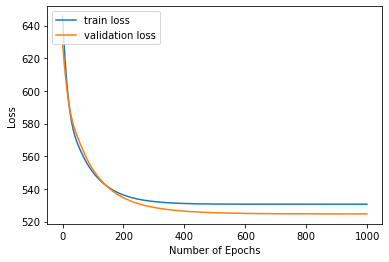

eta Value: 1


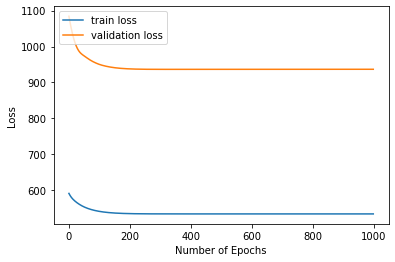

eta Value: 2


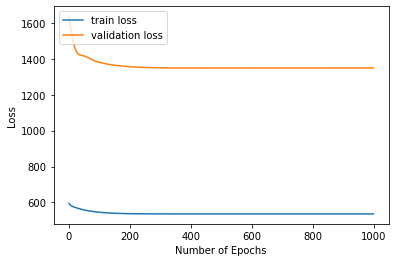

eta Value: 3


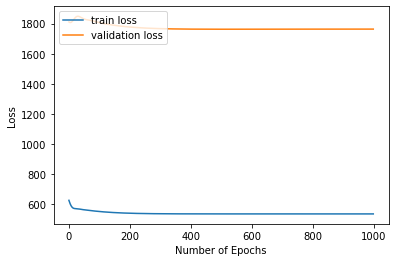

eta Value: 4


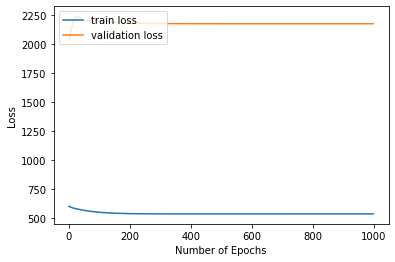

eta Value: 5


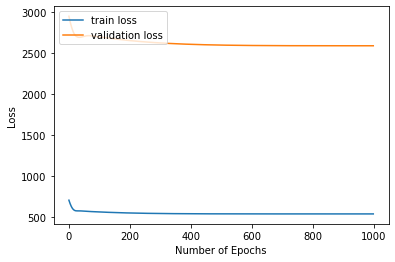

eta Value: 6


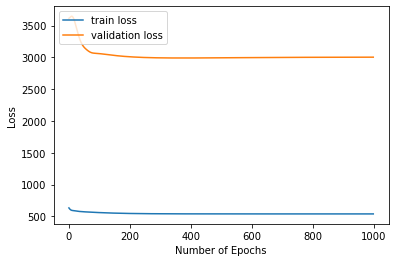

eta Value: 8


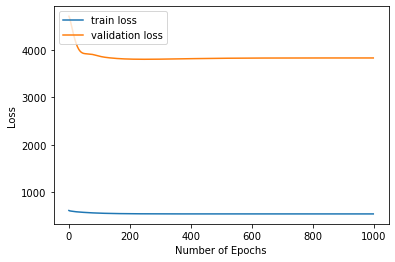

eta Value: 10


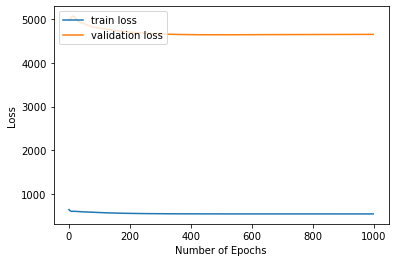

eta Value: 15


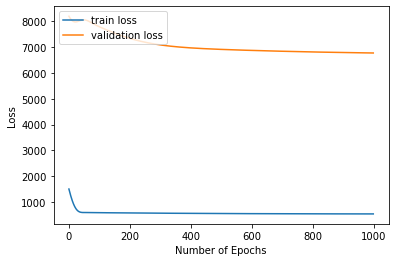

In [ ]:
eta_value_II = [0, 1, 2, 3, 4, 5, 6, 8, 10, 15]
new_evalu = list()
new_evalu_valid = list()
new_evalu_test = list()
for i in range(0, len(eta_value_II)):
    print("eta Value: %d" % eta_value_II[i])
    PR_II = PRLR(eta = eta_value_II[i], epochs = 1000, lr = 0.01)
    new_eva, new_eva_valid, new_eva_test = PR_II.fit(new_X_a_train, y_a_train, new_X_c_train, y_c_train, 
                                                     new_X_a_valid, y_a_valid, new_X_c_valid, y_c_valid, 
                                                     new_X_a_test, y_a_test, new_X_c_test, y_c_test)
    new_evalu.append(new_eva)
    new_evalu_valid.append(new_eva_valid)
    new_evalu_test.append(new_eva_test)

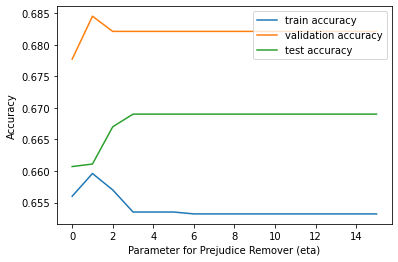

In [ ]:
new_eta_acc_train = [x[0] for x in new_evalu]
new_eta_acc_valid = [x[0] for x in new_evalu_valid]
new_eta_acc_test = [x[0] for x in new_evalu_test]
plt.plot(eta_value_II, new_eta_acc_train, label="train accuracy")
plt.plot(eta_value_II, new_eta_acc_valid, label="validation accuracy")
plt.plot(eta_value_II, new_eta_acc_test, label="test accuracy")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

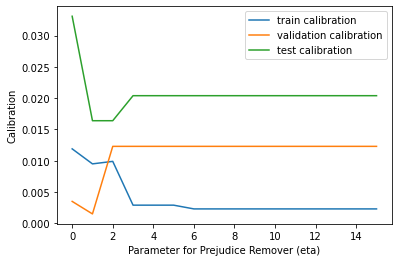

In [ ]:
new_eta_cal_train = [x[1] for x in new_evalu]
new_eta_cal_valid = [x[1] for x in new_evalu_valid]
new_eta_cal_test = [x[1] for x in new_evalu_test]
plt.plot(eta_value_II, new_eta_cal_train, label="train calibration")
plt.plot(eta_value_II, new_eta_cal_valid, label="validation calibration")
plt.plot(eta_value_II, new_eta_cal_test, label="test calibration")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Calibration')
plt.legend(loc="upper right")
plt.show()

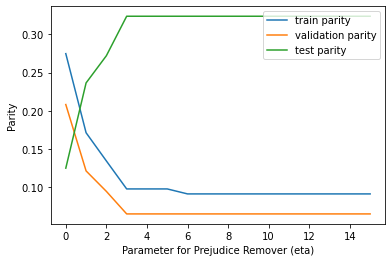

In [ ]:
new_eta_par_train = [x[2] for x in new_evalu]
new_eta_par_valid = [x[2] for x in new_evalu_valid]
new_eta_par_test = [x[2] for x in new_evalu_test]
plt.plot(eta_value_II, new_eta_par_train, label="train parity")
plt.plot(eta_value_II, new_eta_par_valid, label="validation parity")
plt.plot(eta_value_II, new_eta_par_test, label="test parity")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Parity')
plt.legend(loc="upper right")
plt.show()

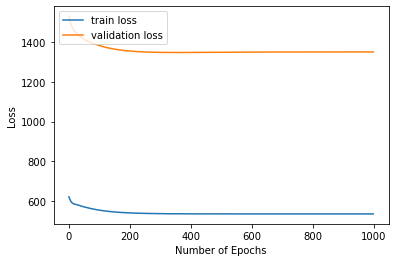

((0.657, 0.0099, 0.1346), (0.6821, 0.0123, 0.0949), (0.667, 0.0164, 0.2719))

In [ ]:
# Final model II
# To achieve high accuracy, low calibration and low parity, we decided to choose eta = 2.
# The outputs are (accuracy, calibration, parity) of training , validation, and testing sets.
new_PR_final = PRLR(eta = 2, epochs = 1000, lr = 0.01)
new_PR_final.fit(new_X_a_train, y_a_train, new_X_c_train, y_c_train, new_X_a_valid, y_a_valid, 
                 new_X_c_valid, y_c_valid, new_X_a_test, y_a_test, new_X_c_test, y_c_test)

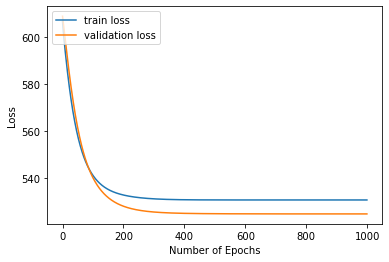

((0.656, 0.0119, 0.2746), (0.6777, 0.0035, 0.2082), (0.6607, 0.0331, 0.1252))

In [ ]:
# Compared to logistic regression without prejudice remover regularizer
PR_0 = PRLR(eta = 0, epochs = 1000, lr = 0.01)
PR_0.fit(new_X_a_train, y_a_train, new_X_c_train, y_c_train, new_X_a_valid, y_a_valid, 
         new_X_c_valid, y_c_valid, new_X_a_test, y_a_test, new_X_c_test, y_c_test)

In [ ]:
# model III
# If we choose different features (which have higher correlation with y):

In [ ]:
compas = pd.read_csv("../data/compas-scores-two-years.csv")

compas = compas[(compas["race"]=='Caucasian') | (compas["race"]=='African-American')]
compas["race_cat"] = compas["race"].apply(lambda x: 1 if x == "Caucasian" else 0)
compas = compas.drop(columns = "race")
compas["gender_cat"] = compas["sex"].apply(lambda x: 1 if x == "Female" else 0)
compas = compas.drop(columns = "sex")
compas["charge_cat"] = compas["c_charge_degree"].apply(lambda x: 1 if x == "F" else 0)
compas = compas.drop(columns = "c_charge_degree")
compas["length_stay"] = pd.to_datetime(compas["c_jail_out"]) - pd.to_datetime(compas['c_jail_in'])
compas["length_stay"] = compas["length_stay"].apply(lambda x: x.days)
compas = compas.drop(columns = ["c_jail_in","c_jail_out"])
compas['length_stay'] = compas["length_stay"].apply(lambda x: 0 if x <= 7 else 0.5 if 7< x <= 90 else 1)
compas["priors_count"] = compas["priors_count"].apply(lambda x: 0 if x==0 else 0.5 if 1<=x<=3 else 1)
compas['age_cat'] = compas['age_cat'].apply(lambda x:0 if x == "Less than 25" else 0.5 if x == "25 - 45" else 1)

In [ ]:
print(compas.corr(method="kendall")['two_year_recid'].sort_values(ascending=False))

two_year_recid             1.000000
is_recid                   0.938762
event                      0.779733
is_violent_recid           0.351163
decile_score               0.303077
decile_score.1             0.303077
v_decile_score             0.257347
priors_count               0.256350
priors_count.1             0.256134
juv_other_count            0.148087
juv_misd_count             0.129031
start                      0.128130
juv_fel_count              0.109672
charge_cat                 0.097831
length_stay                0.081030
days_b_screening_arrest    0.064763
r_days_from_arrest         0.025697
id                         0.009568
c_days_from_compas        -0.052252
gender_cat                -0.099973
race_cat                  -0.118481
age_cat                   -0.153750
age                       -0.155349
end                       -0.600067
violent_recid                   NaN
Name: two_year_recid, dtype: float64


In [ ]:
data = compas[['race_cat', 'is_recid', 'is_violent_recid', 'decile_score', 'age_cat', 'priors_count', 'two_year_recid']]
data = data.dropna()

In [ ]:
data

,race_cat,is_recid,is_violent_recid,decile_score,age_cat,priors_count,two_year_recid
1,0,1,1,3,0.5,0.0,1
2,0,1,0,4,0.0,1.0,1
3,0,0,0,8,0.0,0.5,0
6,1,1,0,6,0.5,1.0,1
8,1,0,0,1,0.5,0.0,0
...,...,...,...,...,...,...,...
7207,0,1,0,2,0.5,0.0,1
7208,0,0,0,9,0.0,0.0,0
7209,0,0,0,7,0.0,0.0,0
7210,0,0,0,3,0.0,0.0,0


In [ ]:
data_a = data[(data['race_cat'] == 0)]
data_c = data[(data['race_cat'] == 1)]
data_a = data_a.drop(columns=["race_cat"])
data_c = data_c.drop(columns=["race_cat"])

Xa = data_a.drop(columns = ['two_year_recid']).copy()
Xc = data_c.drop(columns = ['two_year_recid']).copy()
ya = data_a['two_year_recid']
yc = data_c['two_year_recid']

Xa_train, Xa_tv, ya_train, ya_tv = train_test_split(Xa, ya, train_size=5/7)
Xa_test, Xa_valid, ya_test, ya_valid = train_test_split(Xa_tv, ya_tv, test_size=1/2)
Xc_train, Xc_tv, yc_train, yc_tv = train_test_split(Xc, yc, train_size=5/7)
Xc_test, Xc_valid, yc_test, yc_valid = train_test_split(Xc_tv, yc_tv, test_size=1/2)

Xtrain = pd.concat([Xa_train, Xc_train])
ytrain = pd.concat([ya_train, yc_train])
Xtest = pd.concat([Xa_test, Xc_test])
ytest = pd.concat([ya_test, yc_test])
Xvalid = pd.concat([Xa_valid, Xc_valid])
yvalid = pd.concat([ya_valid, yc_valid])

In [ ]:
Xa_train = t.tensor(np.array(Xa_train)).to(t.float32)
ya_train = t.from_numpy(np.array(ya_train).astype('float32')).reshape(Xa_train.shape[0], 1)
Xc_train = t.tensor(np.array(Xc_train)).to(t.float32)
yc_train = t.from_numpy(np.array(yc_train).astype('float32')).reshape(Xc_train.shape[0], 1)

Xa_test = t.tensor(np.array(Xa_test)).to(t.float32)
ya_test = t.from_numpy(np.array(ya_test).astype('float32')).reshape(Xa_test.shape[0], 1)
Xc_test = t.tensor(np.array(Xc_test)).to(t.float32)
yc_test = t.from_numpy(np.array(yc_test).astype('float32')).reshape(Xc_test.shape[0], 1)

Xa_valid = t.tensor(np.array(Xa_valid)).to(t.float32)
ya_valid = t.from_numpy(np.array(ya_valid).astype('float32')).reshape(Xa_valid.shape[0], 1)
Xc_valid = t.tensor(np.array(Xc_valid)).to(t.float32)
yc_valid = t.from_numpy(np.array(yc_valid).astype('float32')).reshape(Xc_valid.shape[0], 1)

eta Value: 0


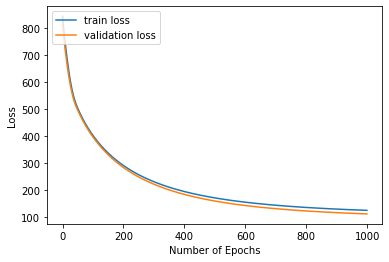

eta Value: 20


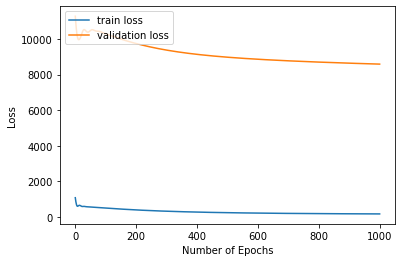

eta Value: 40


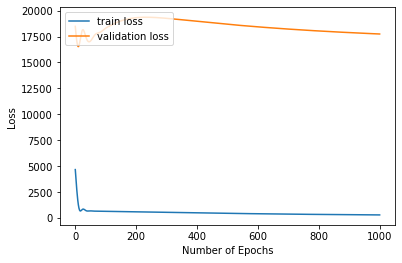

eta Value: 60


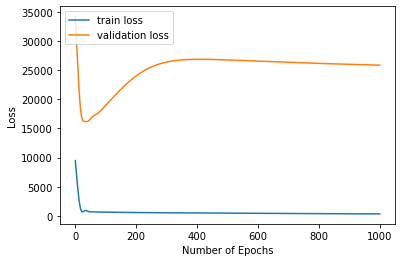

eta Value: 80


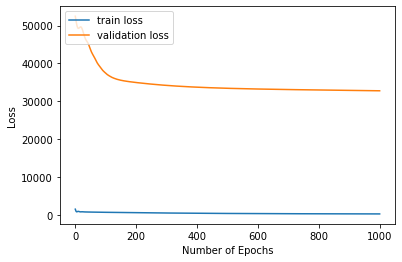

eta Value: 90


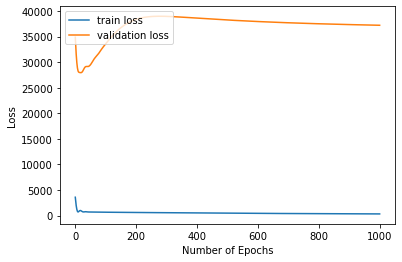

eta Value: 95


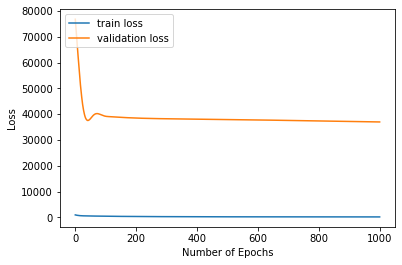

eta Value: 100


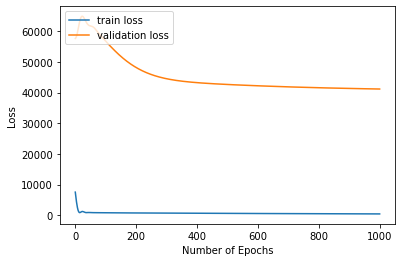

eta Value: 105


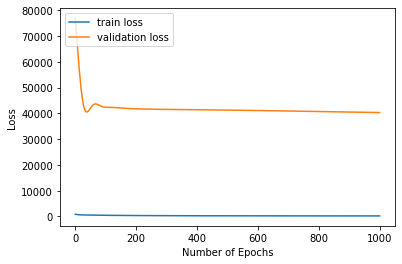

eta Value: 110


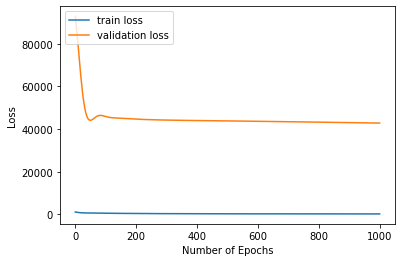

eta Value: 115


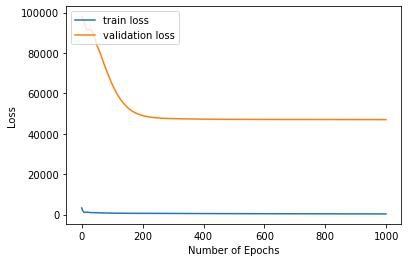

eta Value: 120


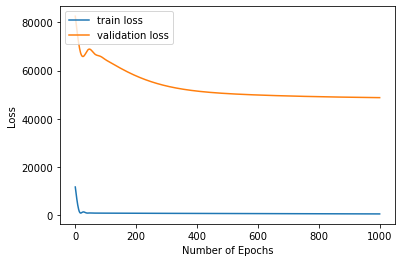

In [ ]:
eta_value_III = [0, 20, 40, 60, 80, 90, 95, 100, 105, 110, 115, 120]
evalu_III = list()
evalu_valid_III = list()
evalu_test_III = list()
for i in range(0, len(eta_value_III)):
    print("eta Value: %d" % eta_value_III[i])
    PR_III = PRLR(eta = eta_value_III[i], epochs = 1000, lr = 0.01)
    eva_III, eva_valid_III, eva_test_III = PR_III.fit(Xa_train, ya_train, Xc_train, yc_train, Xa_valid, ya_valid, 
                                                      Xc_valid, yc_valid, Xa_test, ya_test, Xc_test, yc_test)
    evalu_III.append(eva_III)
    evalu_valid_III.append(eva_valid_III)
    evalu_test_III.append(eva_test_III)

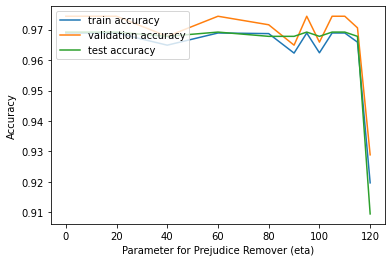

In [ ]:
eta_acc_train_III = [x[0] for x in evalu_III]
eta_acc_valid_III = [x[0] for x in evalu_valid_III]
eta_acc_test_III = [x[0] for x in evalu_test_III]
plt.plot(eta_value_III, eta_acc_train_III, label="train accuracy")
plt.plot(eta_value_III, eta_acc_valid_III, label="validation accuracy")
plt.plot(eta_value_III, eta_acc_test_III, label="test accuracy")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

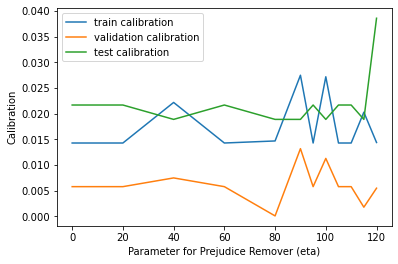

In [ ]:
eta_cal_train_III = [x[1] for x in evalu_III]
eta_cal_valid_III = [x[1] for x in evalu_valid_III]
eta_cal_test_III = [x[1] for x in evalu_test_III]
plt.plot(eta_value_III, eta_cal_train_III, label="train calibration")
plt.plot(eta_value_III, eta_cal_valid_III, label="validation calibration")
plt.plot(eta_value_III, eta_cal_test_III, label="test calibration")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Calibration')
plt.legend(loc="upper left")
plt.show()

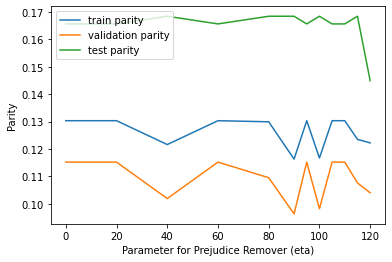

In [ ]:
eta_par_train_III = [x[2] for x in evalu_III]
eta_par_valid_III = [x[2] for x in evalu_valid_III]
eta_par_test_III = [x[2] for x in evalu_test_III]
plt.plot(eta_value_III, eta_par_train_III, label="train parity")
plt.plot(eta_value_III, eta_par_valid_III, label="validation parity")
plt.plot(eta_value_III, eta_par_test_III, label="test parity")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Parity')
plt.legend(loc="upper left")
plt.show()

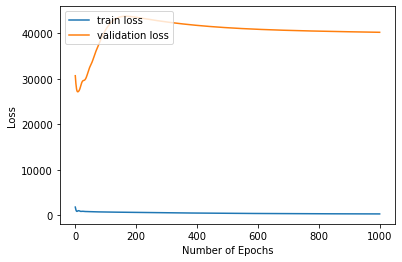

((0.9687, 0.0147, 0.1299), (0.9716, 0.0001, 0.1095), (0.9678, 0.0189, 0.1684))

In [ ]:
# Final model
# To achieve high accuracy, low calibration and low parity, we decided to choose eta = 100.
# The outputs are (accuracy, calibration, parity) of training , validation, and testing sets.
PRfinal = PRLR(eta = 100, epochs = 1000, lr = 0.01)
PRfinal.fit(Xa_train, ya_train, Xc_train, yc_train, Xa_valid, ya_valid, 
            Xc_valid, yc_valid, Xa_test, ya_test, Xc_test, yc_test)

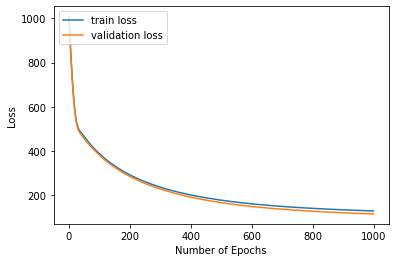

((0.9689, 0.0143, 0.1303), (0.9744, 0.0058, 0.1152), (0.9692, 0.0217, 0.1656))

In [ ]:
# Compared to logitstic regression without prejudice remover regularizer
PR_0 = PRLR(eta = 0, epochs = 1000, lr = 0.01)
PR_0.fit(Xa_train, ya_train, Xc_train, yc_train, Xa_valid, ya_valid, 
         Xc_valid, yc_valid, Xa_test, ya_test, Xc_test, yc_test)

In [ ]:
# model IV
# If we choose all the features:

In [25]:
raw_data=pd.read_csv(data_dir + 'compas-scores-two-years.csv')

In [26]:
df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat',
                    'score_text', 'sex', 'priors_count', 'days_b_screening_arrest',
                    'decile_score', 'is_recid', 'c_jail_in',
                    'c_jail_out', 'two_year_recid']]\
                    .query('days_b_screening_arrest <= 30')\
                    .query('days_b_screening_arrest >= -30')\
                    .query('is_recid != -1')\
                    .query('c_charge_degree != "O"')\
                    .query('score_text != "N/A"')

In [ ]:
df['length_of_stay']=df['c_jail_out'].apply(pd.to_datetime) - df['c_jail_in'].apply(pd.to_datetime)
df['length_of_stay']=df['length_of_stay'].dt.days
races = ['African-American', 'Caucasian']
df = df[df.race.isin(races)]
df.loc[df.race=='Caucasian','race']=1
df.loc[df.race=='African-American','race']=0

cat_var = ['c_charge_degree','race','sex','age_cat','score_text','is_recid','two_year_recid','length_of_stay']

for var in cat_var:
    df[var] = df[var].astype('category').cat.codes

df=df[['sex','age_cat','decile_score','priors_count','days_b_screening_arrest','c_charge_degree','is_recid','score_text','length_of_stay',"race", 'two_year_recid']]

In [28]:
df_aa=df[(df['race'] == 0)]
del df_aa['race']
df_c=df[(df['race'] == 1)]
del df_c['race']
X_aa = df_aa.drop(columns = ['two_year_recid']).copy()
y_aa = df_aa['two_year_recid']

X_c = df_c.drop(columns = ['two_year_recid']).copy()
y_c = df_c['two_year_recid']

In [29]:
df_aa_X_train, df_aa_X_rest, df_aa_y_train, df_aa_y_rest = train_test_split(X_aa,y_aa, train_size=5/7.0)
df_aa_X_valid, df_aa_X_test, df_aa_y_valid, df_aa_y_test = train_test_split(df_aa_X_rest,df_aa_y_rest, test_size=0.5)

df_c_X_train, df_c_X_rest, df_c_y_train, df_c_y_rest = train_test_split(X_c,y_c, train_size=5/7.0)
df_c_X_valid, df_c_X_test, df_c_y_valid, df_c_y_test = train_test_split(df_c_X_rest,df_c_y_rest, test_size=0.5)

X_train=pd.concat([df_aa_X_train,df_c_X_train])
y_train=pd.concat([df_aa_y_train,df_c_y_train])
X_valid=pd.concat([df_aa_X_valid,df_c_X_valid])
y_valid=pd.concat([df_aa_y_valid,df_c_y_valid])
X_test=pd.concat([df_aa_X_test,df_c_X_test])
y_test=pd.concat([df_aa_y_test,df_c_y_test])

df_c_X_train=t.tensor(np.array(df_c_X_train)).to(t.float32)
df_c_y_train=t.from_numpy(np.array(df_c_y_train).astype('float32')).reshape(df_c_X_train.shape[0],1)
df_aa_X_train=t.tensor(np.array(df_aa_X_train)).to(t.float32)
df_aa_y_train=t.from_numpy(np.array(df_aa_y_train).astype('float32')).reshape(df_aa_X_train.shape[0],1)

df_c_X_valid=t.tensor(np.array(df_c_X_valid)).to(t.float32)
df_c_y_valid=t.from_numpy(np.array(df_c_y_valid).astype('float32')).reshape(df_c_X_valid.shape[0],1)
df_aa_X_valid=t.tensor(np.array(df_aa_X_valid)).to(t.float32)
df_aa_y_valid=t.from_numpy(np.array(df_aa_y_valid).astype('float32')).reshape(df_aa_X_valid.shape[0],1)

df_c_X_test=t.tensor(np.array(df_c_X_test)).to(t.float32)
df_c_y_test=t.from_numpy(np.array(df_c_y_test).astype('float32')).reshape(df_c_X_test.shape[0],1)
df_aa_X_test=t.tensor(np.array(df_aa_X_test)).to(t.float32)
df_aa_y_test=t.from_numpy(np.array(df_aa_y_test).astype('float32')).reshape(df_aa_X_test.shape[0],1)

eta Value: 0


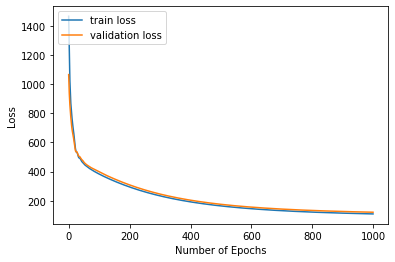

eta Value: 1


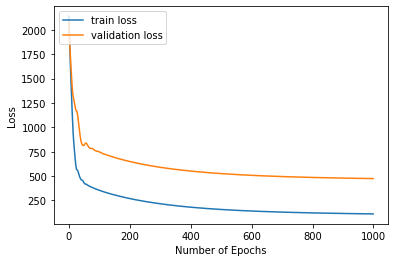

eta Value: 2


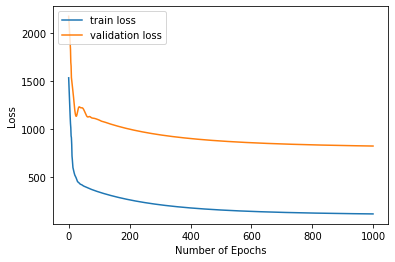

eta Value: 3


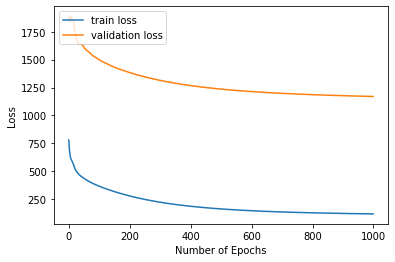

eta Value: 4


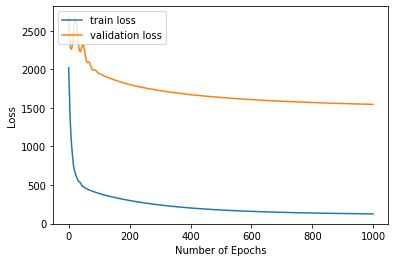

eta Value: 5


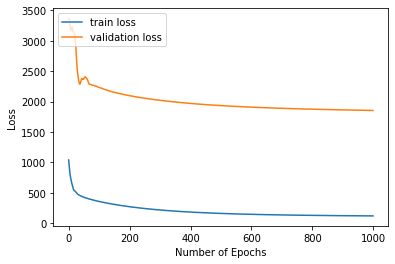

eta Value: 6


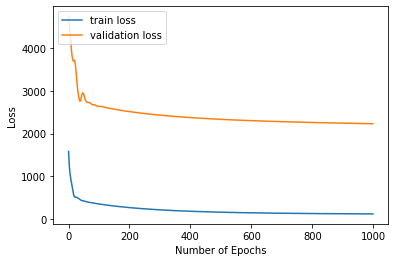

eta Value: 8


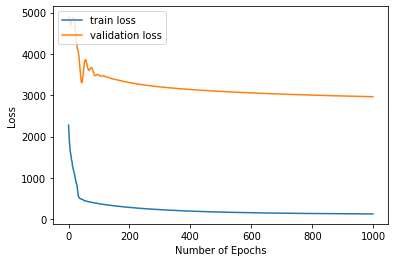

eta Value: 10


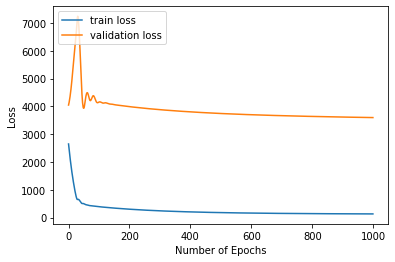

eta Value: 15


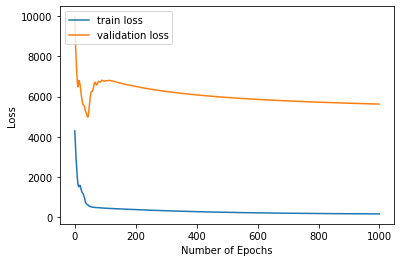

eta Value: 20


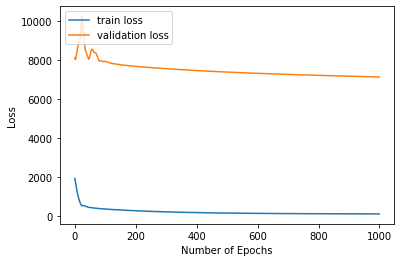

eta Value: 30


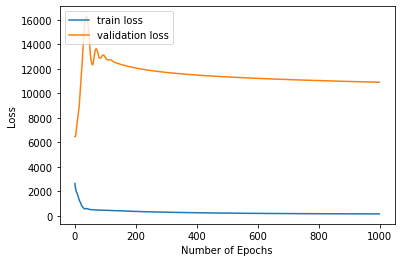

eta Value: 50


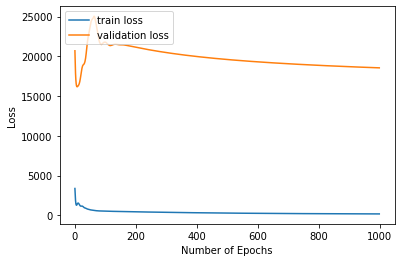

eta Value: 100


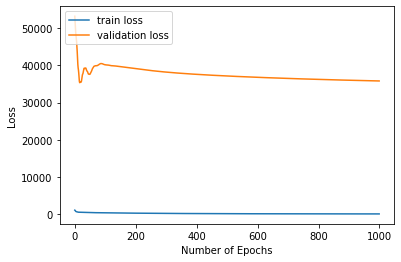

In [31]:
eta_value_IV = [0, 1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 30, 50, 100]
evalu_IV = list()
evalu_valid_IV = list()
evalu_test_IV = list()
for i in range(0, len(eta_value_IV)):
    print("eta Value: %d" % eta_value_IV[i])
    PR_IV = PRLR(eta = eta_value_IV[i], epochs = 1000, lr = 0.01)
    eva_IV, eva_valid_IV, eva_test_IV = PR_IV.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
                                              X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)
    evalu_IV.append(eva_I)
    evalu_valid_IV.append(eva_valid_IV)
    evalu_test_IV.append(eva_test_IV)

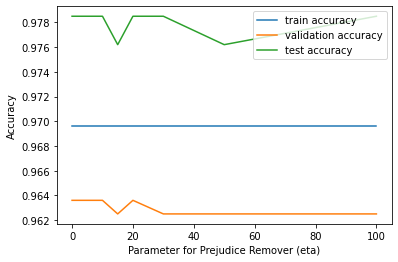

In [32]:
eta_acc_train_IV = [x[0] for x in evalu_IV]
eta_acc_valid_IV = [x[0] for x in evalu_valid_IV]
eta_acc_test_IV = [x[0] for x in evalu_test_IV]
plt.plot(eta_value_IV, eta_acc_train_IV, label="train accuracy")
plt.plot(eta_value_IV, eta_acc_valid_IV, label="validation accuracy")
plt.plot(eta_value_IV, eta_acc_test_IV, label="test accuracy")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

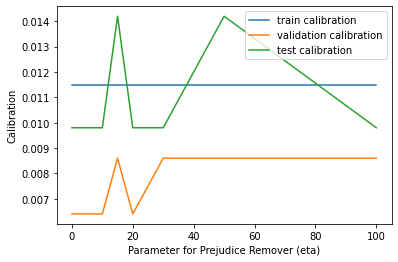

In [33]:
eta_cal_train_IV = [x[1] for x in evalu_IV]
eta_cal_valid_IV = [x[1] for x in evalu_valid_IV]
eta_cal_test_IV = [x[1] for x in evalu_test_IV]
plt.plot(eta_value_IV, eta_cal_train_IV, label="train calibration")
plt.plot(eta_value_IV, eta_cal_valid_IV, label="validation calibration")
plt.plot(eta_value_IV, eta_cal_test_IV, label="test calibration")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Calibration')
plt.legend(loc="upper right")
plt.show()

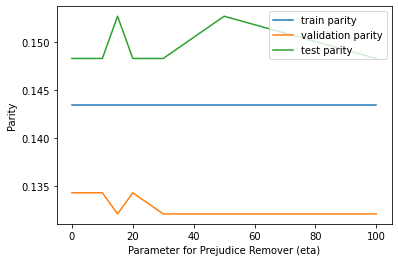

In [34]:
eta_cal_train_IV = [x[2] for x in evalu_IV]
eta_cal_valid_IV = [x[2] for x in evalu_valid_IV]
eta_cal_test_IV = [x[2] for x in evalu_test_IV]
plt.plot(eta_value_IV, eta_cal_train_IV, label="train parity")
plt.plot(eta_value_IV, eta_cal_valid_IV, label="validation parity")
plt.plot(eta_value_IV, eta_cal_test_IV, label="test parity")
plt.xlabel('Parameter for Prejudice Remover (eta)')
plt.ylabel('Parity')
plt.legend(loc="upper right")
plt.show()

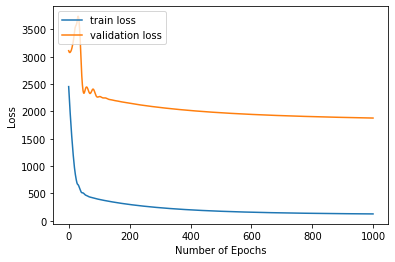

((0.9696, 0.0115, 0.1434), (0.9636, 0.0064, 0.1343), (0.9785, 0.0098, 0.1483))

In [35]:
# Final model IV
# To achieve high accuracy, low calibration and low parity, we decided to choose eta = 5.
# The outputs are (accuracy, calibration, parity) of training , validation, and testing sets.
PR_final_IV = PRLR(eta = 5, epochs = 1000, lr = 0.01)
PR_final_IV.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
               X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)

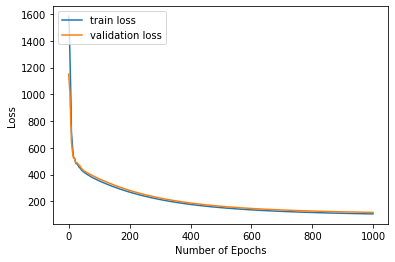

((0.9696, 0.0115, 0.1434), (0.9636, 0.0064, 0.1343), (0.9785, 0.0098, 0.1483))

In [38]:
# Compared to logitstic regression without prejudice remover regularizer
PR_0 = PRLR(eta = 0, epochs = 1000, lr = 0.01)
PR_0.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
               X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)

In [ ]:
# Summary
# as eta increases, accuracy will decrease since it is sacrisfied for fairness, calibration will also decrease, but parity will increase.
# From the figures, we cannot achieve low calibration and low parity at the same time for this problem.
# For this problem, the fairness looks good (calibration below 5% for all models), so the prejudice remover regularizer does not work well.